# R2-A5-S16 Modelo de regresión o clasificación

## Estudiante: José Miguel Méndez Martín

### Ejercicio 1:

--- Primeras filas de Esperanza de Vida (raw) ---
  Country Name Country Code                            Indicator Name  \
0        Aruba          ABW  Esperanza de vida al nacer, total (años)   
1          NaN          AFE  Esperanza de vida al nacer, total (años)   
2   Afganistán          AFG  Esperanza de vida al nacer, total (años)   
3          NaN          AFW  Esperanza de vida al nacer, total (años)   
4       Angola          AGO  Esperanza de vida al nacer, total (años)   

   Indicator Code       1960       1961       1962       1963       1964  \
0  SP.DYN.LE00.IN  64.049000  64.215000  64.602000  64.944000  65.303000   
1  SP.DYN.LE00.IN  44.169257  44.468838  44.877890  45.160583  45.535695   
2  SP.DYN.LE00.IN  32.799000  33.291000  33.757000  34.201000  34.673000   
3  SP.DYN.LE00.IN  37.779636  38.058956  38.681792  38.936918  39.194580   
4  SP.DYN.LE00.IN  37.933000  36.902000  37.168000  37.419000  37.704000   

        1965  ...       2016       2017       2018    

C:\Users\josem\AppData\Local\Temp\ipykernel_6608\2155049644.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_merged['Region'].fillna('Desconocida', inplace=True)
C:\Users\josem\AppData\Local\Temp\ipykernel_6608\2155049644.py:72: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.



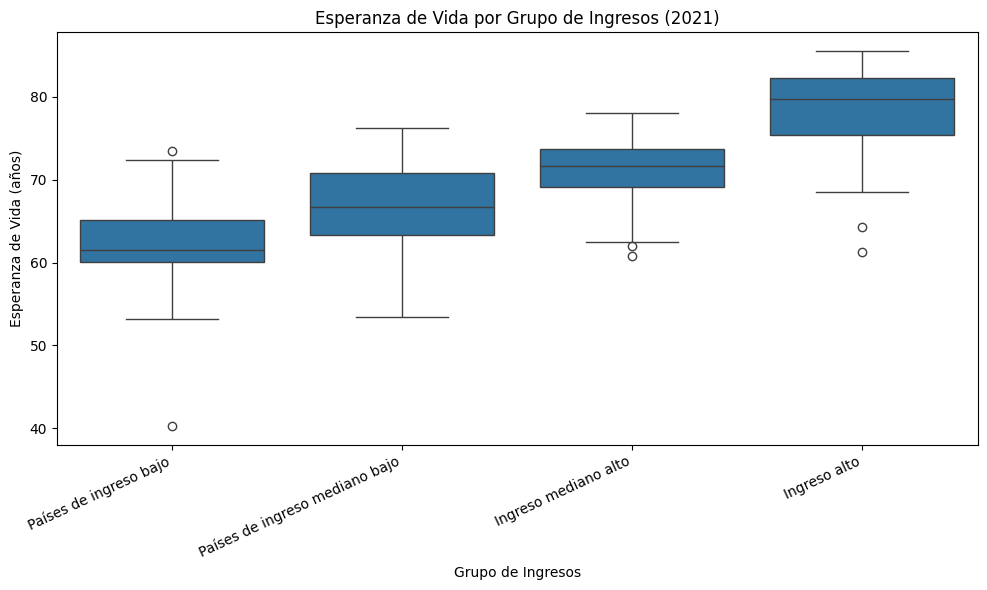

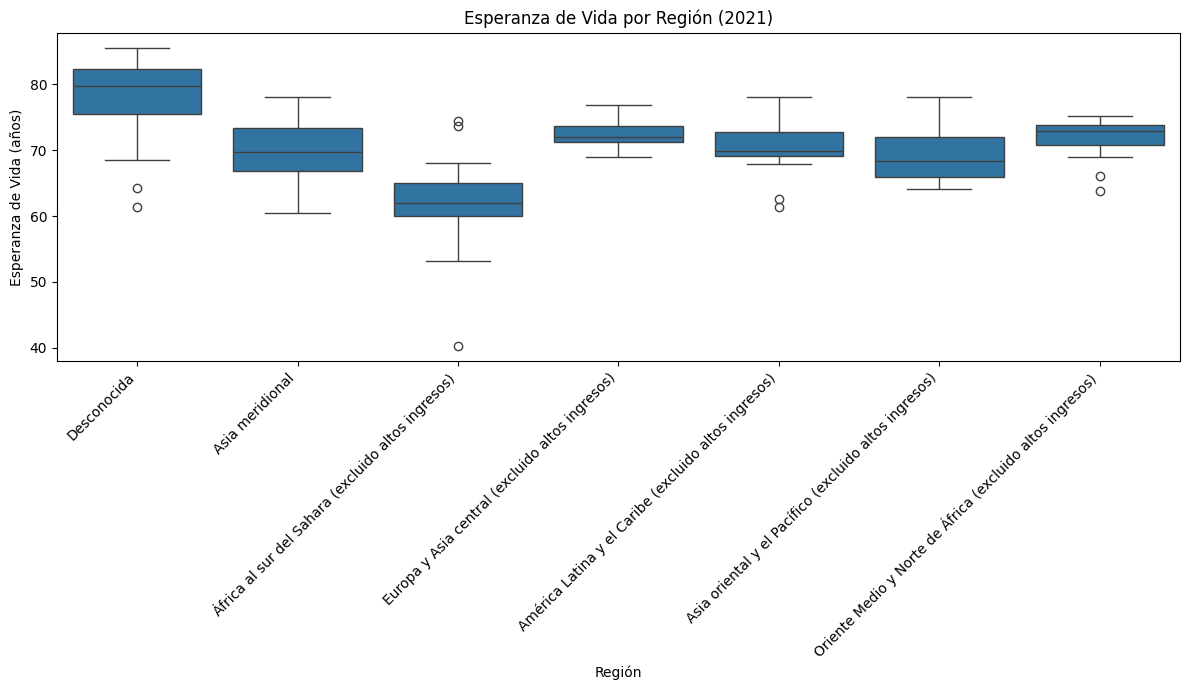

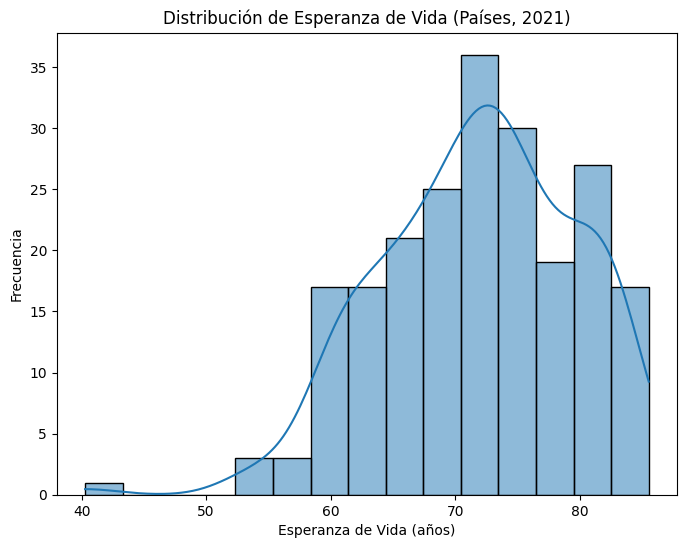

C:\Users\josem\AppData\Local\Temp\ipykernel_6608\2155049644.py:137: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Life_Expectancy', y='Country Name', data=top_10_life_exp, palette='viridis')


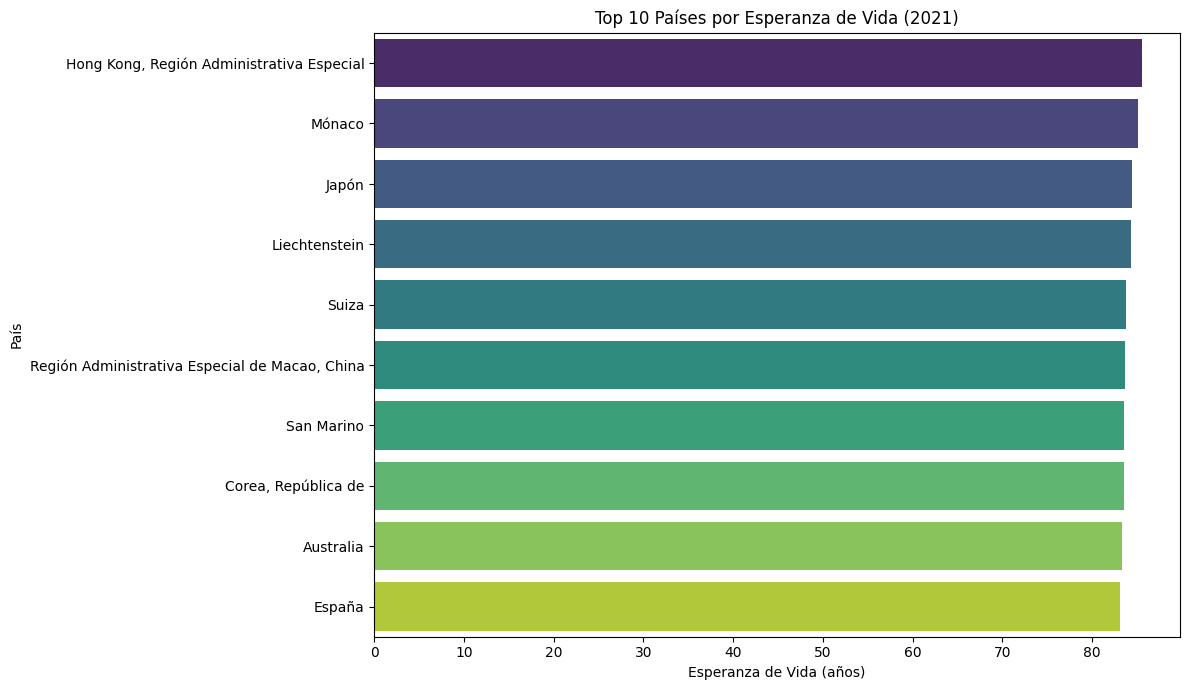

C:\Users\josem\AppData\Local\Temp\ipykernel_6608\2155049644.py:148: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Life_Expectancy', y='Country Name', data=bottom_10_life_exp, palette='rocket')


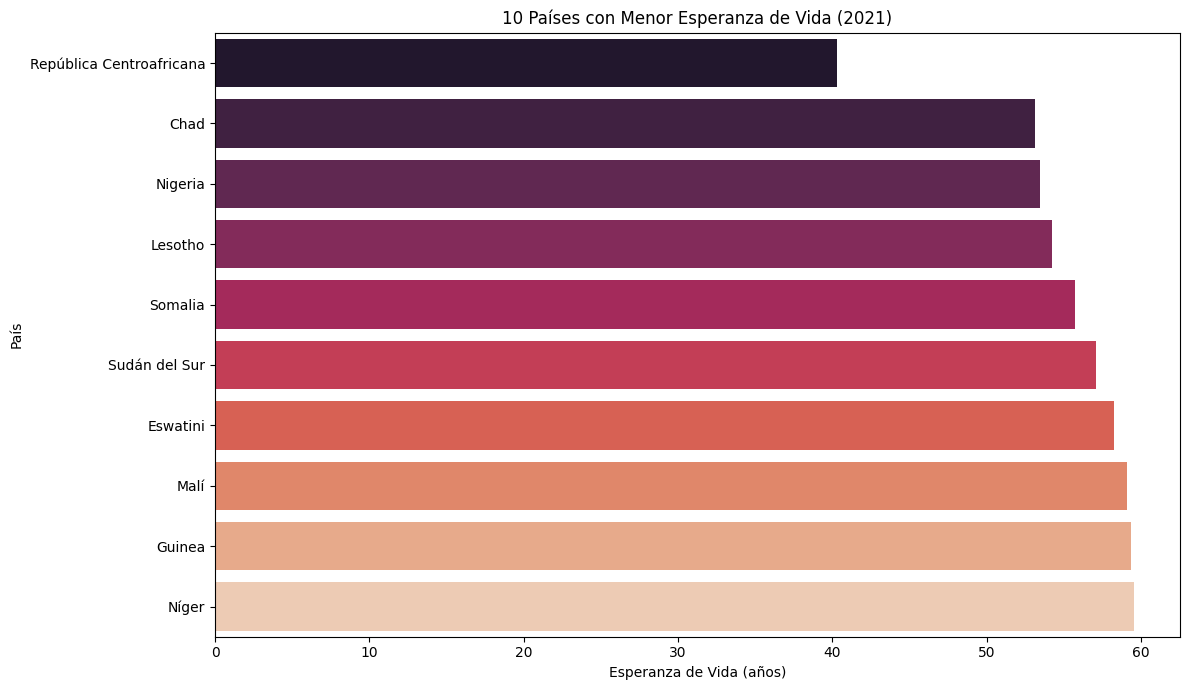

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Cargar los datos ---
# Cargar los datos de esperanza de vida
try:
    # Las primeras dos líneas de tu ejemplo son metadatos, la tercera es el encabezado
    df_life_exp_raw = pd.read_csv('../csv/API_SP.DYN.LE00.IN_DS2_es_csv_v2_86998.csv')
except FileNotFoundError:
    print("Error: 'esperanza_vida_raw.csv' no encontrado. Asegúrate de que el archivo esté en la misma carpeta o proporciona la ruta completa.")
    exit()

# Cargar los metadatos de los países (Región, Grupo de Ingresos)
try:
    df_country_meta = pd.read_csv('../csv/Metadata_Country_API_SP.DYN.LE00.IN_DS2_es_csv_v2_86998.csv')
    # Limpiar posibles espacios en blanco en los nombres de las columnas
    df_country_meta.columns = df_country_meta.columns.str.strip()
except FileNotFoundError:
    print("Error: 'country_metadata.csv' no encontrado. Asegúrate de que el archivo esté en la misma carpeta o proporciona la ruta completa.")
    exit()

print("--- Primeras filas de Esperanza de Vida (raw) ---")
print(df_life_exp_raw.head())
print("\n--- Primeras filas de Metadatos de Países ---")
print(df_country_meta.head())

# --- 2. Transformar datos de Esperanza de Vida a formato largo ---
id_vars_life_exp = ['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code']
value_vars_life_exp = [col for col in df_life_exp_raw.columns if col not in id_vars_life_exp and col.isdigit()]

df_life_exp_long = pd.melt(df_life_exp_raw,
                           id_vars=id_vars_life_exp,
                           value_vars=value_vars_life_exp,
                           var_name='Year',
                           value_name='Life_Expectancy')

df_life_exp_long['Year'] = pd.to_numeric(df_life_exp_long['Year'])
df_life_exp_long['Life_Expectancy'] = pd.to_numeric(df_life_exp_long['Life_Expectancy'], errors='coerce')

print("\n--- Primeras filas de Esperanza de Vida (formato largo) ---")
print(df_life_exp_long.head())

# --- 3. Seleccionar un Año Específico ---
YEAR_TO_ANALYZE = 2021 # Elige un año reciente con datos
df_year_selected = df_life_exp_long[df_life_exp_long['Year'] == YEAR_TO_ANALYZE].copy()
df_year_selected = df_year_selected[['Country Name', 'Country Code', 'Life_Expectancy']] # Solo columnas necesarias

print(f"\n--- Datos de Esperanza de Vida para el año {YEAR_TO_ANALYZE} ---")
print(df_year_selected.head())

# --- 4. Limpiar df_country_meta y Fusionar ---
# Eliminar filas en df_country_meta donde 'Country Name' o 'Country Code' es NaN, si las hay
df_country_meta.dropna(subset=['Country Name', 'Country Code'], inplace=True)
# Seleccionar columnas relevantes de metadatos
df_country_meta = df_country_meta[['Country Name', 'Country Code', 'Region', 'Income_Group']]

df_merged = pd.merge(df_year_selected, df_country_meta, on=['Country Name', 'Country Code'], how='left')

print("\n--- Datos Fusionados (Esperanza de Vida + Metadatos) ---")
print(df_merged.head())
df_merged.info()

# --- 5. Manejar Valores Faltantes en el DataFrame Fusionado ---
# Importante: Eliminar filas donde la Esperanza de Vida es NaN
df_merged.dropna(subset=['Life_Expectancy'], inplace=True)

# Para 'Region' e 'Income_Group', puedes rellenar NaNs con "Desconocido" o eliminar esas filas
# Aquí los rellenaremos para no perder países si solo falta esta info categórica
df_merged['Region'].fillna('Desconocida', inplace=True)
df_merged['Income_Group'].fillna('Desconocido', inplace=True)

# Filtrar agregados (ej. donde Income_Group es 'Agregados' o Region está vacía o es 'Desconocida' si eso identifica agregados)
# Basado en tus datos, parece que los agregados tienen 'Income_Group' vacío o no especificado
# Los países con 'Country Code' como AFE, AFW, ARB también son agregados.
# Una forma más robusta sería tener una lista de códigos de agregados o filtrar por 'Income_Group' no siendo uno de los grupos de ingreso de países.
# Por ahora, vamos a filtrar donde 'Income_Group' NO es 'Agregados' (si es que existe esa categoría)
# Y donde 'Region' no sea 'Desconocida' si eso implica un agregado
# Y donde 'Country Code' no sea uno de los códigos de agregados conocidos (AFE, AFW, ARB...)
known_aggregate_codes = ['AFE', 'AFW', 'ARB', 'CEA', 'CEB', 'ECS', 'EMU', 'EUU', 'FCS', 'HIC', 'HPC', 'IBD', 'IBT', 'IDA', 'IDX', 'LAC', 'LCN', 'LDC', 'LIC', 'LMC', 'LMY', 'LTE', 'MEA', 'MIC', 'MNA', 'NAC', 'OED', 'OSS', 'PRE', 'PSS', 'PST', 'SAS', 'SSA', 'SSF', 'SST', 'TEA', 'TEC', 'TLA', 'TMN', 'TSA', 'UMC', 'WLD'] # Lista incompleta, necesitas revisar los datos del Banco Mundial
df_countries_only = df_merged[~df_merged['Country Code'].isin(known_aggregate_codes)].copy()

# También filtrar por filas donde 'Income_Group' podría indicar un agregado (ej. si contiene la palabra 'aggregate')
if 'Income_Group' in df_countries_only.columns:
     df_countries_only = df_countries_only[~df_countries_only['Income_Group'].str.contains('aggregate', case=False, na=False)]
     # Filtrar para asegurar que Income_Group sea uno de los válidos (ej. 'Ingreso alto', 'Países de ingreso bajo', etc.)
     valid_income_groups = ['Ingreso alto', 'Países de ingreso bajo', 'Países de ingreso mediano bajo', 'Ingreso mediano alto'] # Ajusta según tus datos
     df_countries_only = df_countries_only[df_countries_only['Income_Group'].isin(valid_income_groups)]


print(f"\n--- Datos Solo de Países (después de filtrar agregados) para {YEAR_TO_ANALYZE} ---")
print(df_countries_only.head())
print(f"Número de países después de filtrar: {len(df_countries_only)}")

if df_countries_only.empty:
    print(f"No quedan datos de países después de filtrar para el año {YEAR_TO_ANALYZE}. Revisa los filtros o el año.")
    exit()

# --- 6. ¡TU PRIMER OBJETO VISUAL! ---
# Por ejemplo, Esperanza de Vida promedio por Grupo de Ingresos

plt.figure(figsize=(10, 6))
sns.boxplot(x='Income_Group', y='Life_Expectancy', data=df_countries_only,
            order=['Países de ingreso bajo', 'Países de ingreso mediano bajo', 'Ingreso mediano alto', 'Ingreso alto']) # Ordenar categorías
plt.title(f'Esperanza de Vida por Grupo de Ingresos ({YEAR_TO_ANALYZE})')
plt.xlabel('Grupo de Ingresos')
plt.ylabel('Esperanza de Vida (años)')
plt.xticks(rotation=25, ha='right') # Rotar etiquetas para mejor lectura
plt.tight_layout() # Ajustar layout para que todo quepa
plt.show()

# --- SEGUNDO OBJETO VISUAL ---
# Esperanza de Vida promedio por Región
plt.figure(figsize=(12, 7))
sns.boxplot(x='Region', y='Life_Expectancy', data=df_countries_only)
plt.title(f'Esperanza de Vida por Región ({YEAR_TO_ANALYZE})')
plt.xlabel('Región')
plt.ylabel('Esperanza de Vida (años)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# --- TERCER OBJETO VISUAL ---
# Histograma de Esperanza de Vida para los países seleccionados
plt.figure(figsize=(8, 6))
sns.histplot(df_countries_only['Life_Expectancy'], kde=True, bins=15)
plt.title(f'Distribución de Esperanza de Vida (Países, {YEAR_TO_ANALYZE})')
plt.xlabel('Esperanza de Vida (años)')
plt.ylabel('Frecuencia')
plt.show()

# --- CUARTO OBJETO VISUAL (Ejemplo) ---
# Países con mayor esperanza de vida
top_10_life_exp = df_countries_only.nlargest(10, 'Life_Expectancy')
plt.figure(figsize=(12, 7))
sns.barplot(x='Life_Expectancy', y='Country Name', data=top_10_life_exp, palette='viridis')
plt.title(f'Top 10 Países por Esperanza de Vida ({YEAR_TO_ANALYZE})')
plt.xlabel('Esperanza de Vida (años)')
plt.ylabel('País')
plt.tight_layout()
plt.show()

# --- QUINTO OBJETO VISUAL (Ejemplo) ---
# Países con menor esperanza de vida
bottom_10_life_exp = df_countries_only.nsmallest(10, 'Life_Expectancy')
plt.figure(figsize=(12, 7))
sns.barplot(x='Life_Expectancy', y='Country Name', data=bottom_10_life_exp, palette='rocket')
plt.title(f'10 Países con Menor Esperanza de Vida ({YEAR_TO_ANALYZE})')
plt.xlabel('Esperanza de Vida (años)')
plt.ylabel('País')
plt.tight_layout()
plt.show()

# Con esto ya tienes 5 visualizaciones y un DataFrame ('df_countries_only')
# que está listo para ser enriquecido con MÁS INDICADORES PREDICTORES
# para tu modelo de regresión.